In [20]:
#setwd('/Users/alexis/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/CEMALB_DataAnalysisPM/Projects/P1012. NC Well Arsenic/P1012.2. Analyses/P1012.2.3. ML Visualizations/Input)
Output = ('/Users/alexis/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/CEMALB_DataAnalysisPM/Projects/P1012. NC Well Arsenic/P1012.2. Analyses/P1012.2.3. ML Visualizations//Output')
cur_date = "052323"

library(readxl)
library(lubridate)
library(tidyverse)
library(randomForest)

library(MetBrewer)
library(e1071)
library(themis)

#reading in files
well_data = data.frame(read_excel("Input/Imputed_Well_Data_051023.xlsx")) 

Loading required package: recipes


Attaching package: ‘recipes’


The following object is masked from ‘package:stringr’:

    fixed


The following object is masked from ‘package:stats’:

    step




In [21]:
head(well_data)

,Tax_ID,Health_Dept_ID,Permit_No,Water_Sample_Date,Casing_Depth,Well_Depth,Static_Water_Depth,Flow_Rate,pH,Metal,Concentration,Detect_Concentration
,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>
1,1006004,960,12-155,9/24/12,52,165,41,60.0,7.7,Ar,1.438029,ND
2,1024009,1803,15-177,12/17/15,40,445,42,2.0,7.3,Ar,1.863054,ND
3,1054019,1647,14-212,2/2/15,45,160,40,40.0,7.4,Ar,1.434020,ND
4,1057017,970,12-169,10/22/12,42,440,57,1.5,8.0,Ar,35.000000,D
5,1060006,533,10-239,1/3/11,48,120,42,25.0,7.1,Ar,1.470804,ND
6,1066006,1795,15-224,12/15/15,60,280,32,10.0,8.2,Ar,53.000000,D


In supervised machine learning, decision boundaries help assess how well two predictors (on the x and y axis) separate different classes in classification. A clear decision boundary has most classes well separated.

In [22]:
arsenic_data = well_data %>%
    mutate(Five_Threshold = relevel(factor(ifelse(Concentration >= 5, 1, 0)), ref = "0"),
          Ten_Threshold = relevel(factor(ifelse(Concentration >= 10, 1, 0)), ref = "0"),
           # making this col into a factor
          Detect_Concentration = relevel(factor(ifelse(Detect_Concentration == "D", 1, 0)), ref = "0"),
          # converting water sample date from a character to a date type
          Water_Sample_Date = mdy(Water_Sample_Date)) %>%

    # filtering for Arsenic only
    filter(Metal == "Ar")


head(arsenic_data)

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `Water_Sample_Date = mdy(Water_Sample_Date)`.
Caused by warning:
!  9 failed to parse.”


,Tax_ID,Health_Dept_ID,Permit_No,Water_Sample_Date,Casing_Depth,Well_Depth,Static_Water_Depth,Flow_Rate,pH,Metal,Concentration,Detect_Concentration,Five_Threshold,Ten_Threshold
,<chr>,<dbl>,<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<fct>,<fct>,<fct>
1,1006004,960,12-155,2012-09-24,52,165,41,60.0,7.7,Ar,1.438029,0,0,0
2,1024009,1803,15-177,2015-12-17,40,445,42,2.0,7.3,Ar,1.863054,0,0,0
3,1054019,1647,14-212,2015-02-02,45,160,40,40.0,7.4,Ar,1.434020,0,0,0
4,1057017,970,12-169,2012-10-22,42,440,57,1.5,8.0,Ar,35.000000,1,1,1
5,1060006,533,10-239,2011-01-03,48,120,42,25.0,7.1,Ar,1.470804,0,0,0
6,1066006,1795,15-224,2015-12-15,60,280,32,10.0,8.2,Ar,53.000000,1,1,1


In [23]:
# creating dfs for each outcome
# dropped 3 rows that had missing dates
arsenic_detect_df = drop_na(arsenic_data[,c(4:9,12)])  
arsenic_five_df = drop_na(arsenic_data[,c(4:9,13)]) 
arsenic_ten_df = drop_na(arsenic_data[,c(4:9,14)])

head(arsenic_detect_df)

,Water_Sample_Date,Casing_Depth,Well_Depth,Static_Water_Depth,Flow_Rate,pH,Detect_Concentration
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,2012-09-24,52,165,41,60.0,7.7,0
2,2015-12-17,40,445,42,2.0,7.3,0
3,2015-02-02,45,160,40,40.0,7.4,0
4,2012-10-22,42,440,57,1.5,8.0,1
5,2011-01-03,48,120,42,25.0,7.1,0
6,2015-12-15,60,280,32,10.0,8.2,1


# Decision Boundary Calculation

In [58]:
# creating a df with variables that we're interested in 
# don't use well depth
smaller_arsenic_data = data.frame(arsenic_ten_df[,c("Static_Water_Depth", "pH", "Ten_Threshold")])

# using smote first to balance classes
balanced_data = smotenc(smaller_arsenic_data, "Ten_Threshold")

# predicting
svm_detect_arsenic = svm(Ten_Threshold~., data = balanced_data, kernel = "radial")

In [59]:
# obtaining grid values and predictions visualize using ggplot
get_grid_df <- function(model, data, class = NULL, predict_type = "class",
  resolution = 100, showgrid = TRUE, ...) {

  # plotting original data
  if(!is.null(class)) cl <- data[,class] else cl <- 1
  data <- data[,1:2]
  k <- length(unique(cl))

  # make grid (between min and max for each variable)
  r <- sapply(data, range, na.rm = TRUE)
  xs <- seq(r[1,1], r[2,1], length.out = resolution)
  ys <- seq(r[1,2], r[2,2], length.out = resolution)
  g <- cbind(rep(xs, each=resolution), rep(ys, time = resolution))
  colnames(g) <- colnames(r)
  g <- as.data.frame(g)
    
  ### guess how to get class labels from predict
  ### (unfortunately not very consistent between models)
  p <- predict(model, g, type = predict_type)
  g$Pred_Class = p
    
  return(g)
}

# calling function
grid_df_arsenic_detect = get_grid_df(svm_detect_arsenic, balanced_data, class = "Ten_Threshold")
head(grid_df_arsenic_detect)

,Static_Water_Depth,pH,Pred_Class
,<dbl>,<dbl>,<fct>
1,1,5.400000,0
2,1,5.446465,0
3,1,5.492929,0
4,1,5.539394,0
5,1,5.585859,0
6,1,5.632323,0


# Decision Boundary Plot

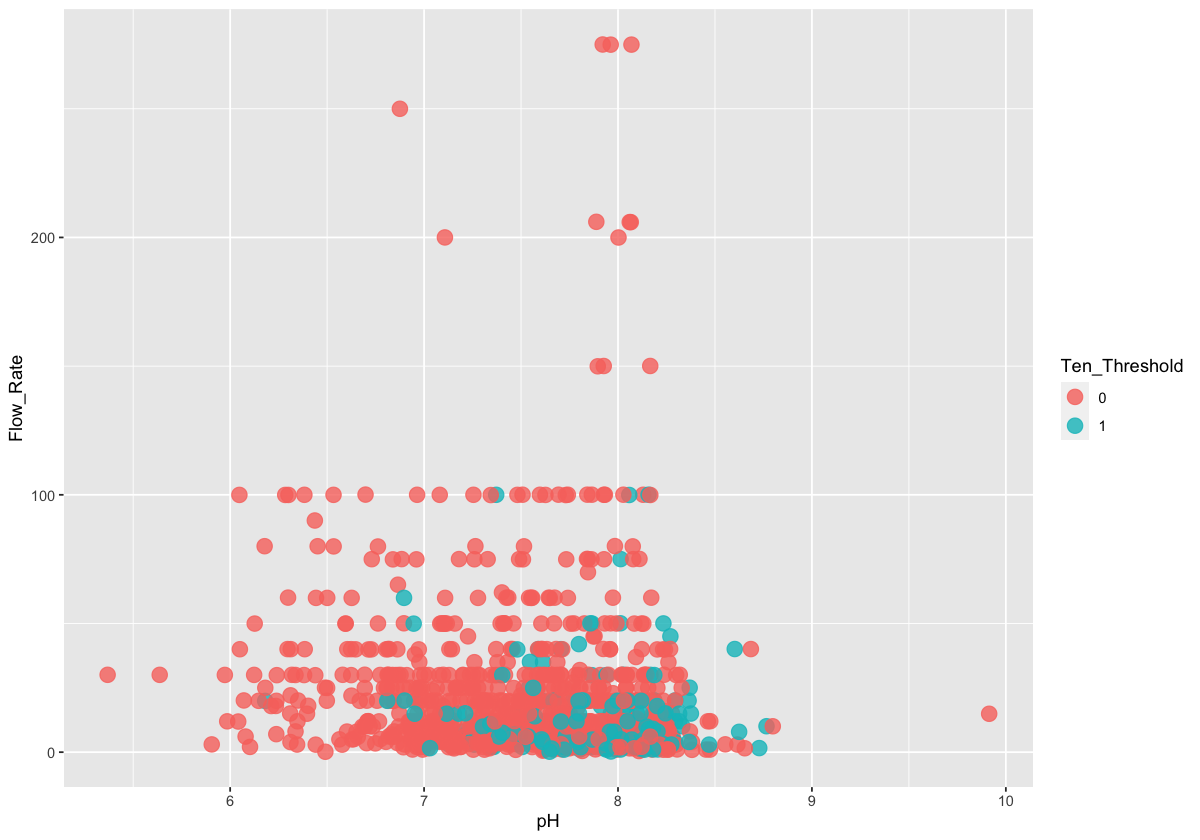

In [68]:
options(repr.plot.width=10, repr.plot.height=7) #changing size

#choosing palette from package
metbrewer_colors = MetPalettes$Lakota[[1]]

ggplot() +
  geom_point(data = arsenic_ten_df, aes(x = pH, y = Flow_Rate, color = Ten_Threshold),
            position = position_jitter(w = 0.1, h = 0.1), size = 4, alpha = 0.8) #+ 
#   geom_contour(data = grid_df_arsenic_detect, aes(x = Static_Water_Depth, y = pH, z = as.numeric(Pred_Class == "1")), 
#                color = "black", breaks = 0.5) + #adds contour line
#   geom_point(data = grid_df_arsenic_detect, aes(x = Static_Water_Depth, y = pH, color = Pred_Class), 
#              size = 0.1) + #shades plot

#   theme_light() + 
#   theme(axis.line = element_line(colour = "black"), #making x and y axes black
#         axis.text = element_text(size = 12), #changing size of x axis labels
#         axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
#         legend.title = element_text(face = 'bold', size = 14), #changes legend title
#         legend.text = element_text(size = 12), #changes legend text
#         legend.position = c(0.2,0.8), # move legend to top left corner
#         legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
#         strip.text.x = element_text(size = 15, face = "bold"), #changes size of facet x axis 
#         strip.text.y = element_text(size = 15, face = "bold")) + #changes size of facet y axis 
#   labs(x = 'Static_Water_Depth', y = 'pH (??)') + #changing axis labels 

#   scale_color_manual(name = "EPA Max\nContainment Level",
#                       values = c(metbrewer_colors[5], metbrewer_colors[2]),
#                       labels = c('Below','Above'))  #reordering